In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.io

from operations import *
from plots import *

In [2]:
# Load data
mat_file = scipy.io.loadmat("../data/data.mat")
data = np.array(mat_file["stack"])

# 480, 480, 9
sizeX, sizeY, sizeZ = data.shape

# shape = (1, 1, 9, 3)
depthCode = np.array(mat_file["depthCode"])

In [3]:
# Imaging parameters
NA = 0.4            # objective numerical aperture
dz = 20.56          # delta z (um)
dx = 1.083          # lateral pixel size (um)
wavelength = 0.51   # um
n = 1.0             # refractive index

# Optimization parameters
TV_reg = 0          # amount of TV regularization
xy_pad = 50         # lateral volume extension
z_pad = 8           # axial volume extension
outer_iter = 4    # outer iterations of EV-3D algorithm
inner_iter = 8     # inner iterations of EV-3D algorithm

In [4]:
### EV-3D deconvolution ###
# deconv shape: 580, 580, 25
deconv_sizeX = sizeX + 2 * xy_pad
deconv_sizeY = sizeY + 2 * xy_pad
deconv_sizeZ = sizeZ + 2 * z_pad

# Point spread function (PSF)
psf = ComputeGaussianPSF(NA, wavelength, dx, dz, (deconv_sizeX, deconv_sizeY, int(deconv_sizeZ / 2)), n)

# Optical transfer function (OTF)
otf = GenerateOTF(psf, [deconv_sizeX, deconv_sizeY, deconv_sizeZ])

In [5]:
image_ev = np.pad(data, ((xy_pad, xy_pad), (xy_pad, xy_pad), (z_pad, z_pad)), mode='edge')

image_mask = np.pad(data, ((xy_pad, xy_pad), (xy_pad, xy_pad), (z_pad, z_pad)), mode='constant', constant_values=0)
image_mask = np.where(image_mask > 0)
obs = data[data > 0]

In [6]:
est = 0
for i in range(0, outer_iter):
    print("[Outer Iteration] #", str(i+1), sep='')
    est = RL_TV(image_ev, otf, inner_iter, TV_reg)
    image_ev = (np.fft.ifftn(np.fft.fftn(est) * otf)).real
    image_ev = np.maximum(image_ev, 0)
    image_ev[image_mask] = obs

EVdeconv = est[(xy_pad):(xy_pad+sizeX), (xy_pad):(xy_pad+sizeY), (z_pad):(z_pad+
                                                                          sizeZ)]

[Outer Iteration] #1
[Inner Iteration] #1
[Inner Iteration] #2
[Inner Iteration] #3
[Inner Iteration] #4
[Inner Iteration] #5
[Inner Iteration] #6
[Inner Iteration] #7
[Inner Iteration] #8
[Outer Iteration] #2
[Inner Iteration] #1
[Inner Iteration] #2
[Inner Iteration] #3
[Inner Iteration] #4
[Inner Iteration] #5
[Inner Iteration] #6
[Inner Iteration] #7
[Inner Iteration] #8
[Outer Iteration] #3
[Inner Iteration] #1
[Inner Iteration] #2
[Inner Iteration] #3
[Inner Iteration] #4
[Inner Iteration] #5
[Inner Iteration] #6
[Inner Iteration] #7
[Inner Iteration] #8
[Outer Iteration] #4
[Inner Iteration] #1
[Inner Iteration] #2
[Inner Iteration] #3
[Inner Iteration] #4
[Inner Iteration] #5
[Inner Iteration] #6
[Inner Iteration] #7
[Inner Iteration] #8


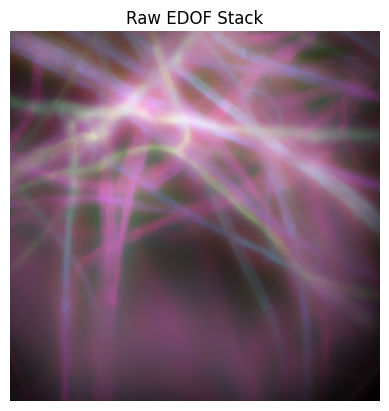

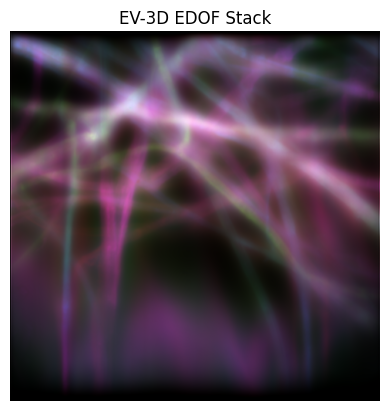

In [7]:
plotResults(data, EVdeconv, depthCode)